# 《机器学习》从零开始学(30) 概率图模型专题之马尔可夫网表示 

参考教材：

    1）机器学习-周志华-清华大学出版社-2016  链接:https://pan.baidu.com/s/1c1DSE2W 密码:gufi
    2）概率图模型：原理与技术-[美]D·科勒＆[以色列]N·弗里德曼-王飞跃＆韩素青(译)-清华大学出版社-2015  链接:https://pan.baidu.com/s/1dEBk2rf 密码:77hq

所谓“从零开始”面向的对象其实仅指我本人。也就是我的学习笔记。

**注意**：

1. 此笔记是在我理解基础上的梳理和表述。 

2. 本笔记的代码无法在聚宽上运行，请复制到本地运行(Python2.7，并安装[pgmpy](https://github.com/pgmpy)及其依赖库)。

3. 由于概率图模型有不少难点，所以本笔记不追求自己实现算法，而利用一个冷门库**[pgmpy](http://pgmpy.org/)**作为演练工具（我暂时没有找到更适合的），而具体算法部分可能会从其源代码中截取一段代码做示例。

4. 我隐隐感觉，在**tensorflow**框架下也应该可以实现概率图模型，这方面留到以后研究吧。

本节重点在 马尔可夫网（无向图模型）表示、及其基本概念。我作为初学者，仅仅对其关键之处做了笔记。  本笔记的Python代码很少，也不重要。

## 1）马尔可夫网初识

**贝叶斯网**是根据节点依赖关系构成有向无环图，进而引申出每个节点的**条件概率分布**来表征其对父节点的依赖。 但**马尔可夫网**节点间的依赖关系是无向的（相互平权的关系），无法用**条件概率分布**来表示，为此为引入“**极大团**”概念，进而为每个“**极大团**”引入一个“**势函数**”作为因子，然后将联合概率分布表示成这些因子的乘积再归一化，归一化常数被称作“**配分函数**”。 【双引号中的概念后面再解释】。

**马尔可夫网**，也常被称作**马尔可夫随机场**。

先上图形成一个感性认识（暂时忽略Python代码，直接看运行结果，图中表格就是对应“**极大团**”的“**势函数**”）：

【注意】**贝叶斯网**的**条件概率分布**在图中是指向节点的；而**马尔可夫网**的“**势函数**”在图中是指向“**极大团**”的，下图的每个“**极大团**”都只有两个节点，所以指向对应节点的连线。

验证模型数据的正确性: True


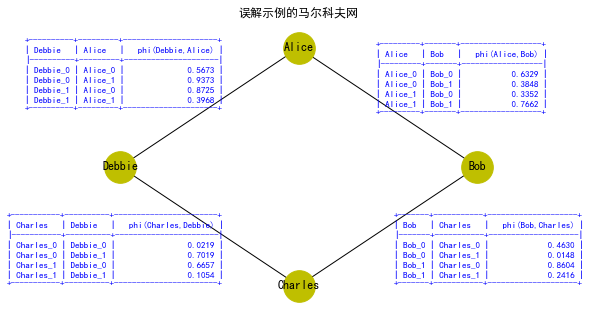

In [2]:
import numpy as np
import networkx as nx

from pgmpy.models import MarkovModel
from pgmpy.factors.discrete import DiscreteFactor

import matplotlib.pyplot as plt
%matplotlib inline


# 建立一个简单马尔科夫网
model = MarkovModel([('Alice', 'Bob'), ('Bob', 'Charles'), ('Charles', 'Debbie'), ('Debbie', 'Alice')])

# 各团因子(参数随机选择)
factor_ab = DiscreteFactor(['Alice', 'Bob'], cardinality=[2,2], values=np.random.rand(4))
factor_bc = DiscreteFactor(['Bob', 'Charles'], cardinality=[2,2], values=np.random.rand(4))
factor_cd = DiscreteFactor(['Charles', 'Debbie'], cardinality=[2,2], values=np.random.rand(4))
factor_da = DiscreteFactor(['Debbie', 'Alice'], cardinality=[2,2], values=np.random.rand(4))

# 将各团因子加入网络
model.add_factors(factor_ab,factor_bc,factor_cd,factor_da)

# 验证模型数据的正确性
print u"验证模型数据的正确性:",model.check_model()

# # 绘制贝叶斯图(节点+依赖关系)
nx.draw(model, with_labels=True, node_size=1000, font_weight='bold', node_color='y', \
        pos={"Alice":[5,8],"Bob":[8,5],"Charles":[5,2],"Debbie":[2,5]})
plt.text(6.3,6.3,model.get_factors()[0], fontsize=9, color='b')
plt.text(6.6,2,model.get_factors()[1], fontsize=9, color='b')
plt.text(0.1,2,model.get_factors()[2], fontsize=9, color='b')
plt.text(0.4,6.4,model.get_factors()[3], fontsize=9, color='b')
plt.title(u"误解示例的马尔科夫网")
plt.show()

## 2） 马尔可夫网联合概率分布的一般形式-吉布斯分布

和贝叶斯网类似，**马尔可夫网**也能够简化属性间联合概率分布，但不是以局部概率模型（条件概率分布）形式简化的。

假设一个**属性集**的任何两个属性都相互关联，那么这个**属性集**的**联合概率分布**是无法简化的，我们称这样的**属性集**为**团**。 

很自然，我们可以考虑把**马尔可夫网**变成一系列**团**的集合，但这里有个问题：**团**和**团**之间可能存在包含关系。为了解决这个问题，我们引入了**极大团**概念，就是不能被其他**团**包含的团。 

于是**马尔可夫网**可以看成是被一系列**极大团**的集合，称之为**团分解**。进而，**马尔可夫网**的**联合概率分布**能够被**团分解**成一系列因子的乘积，每个因子仅仅与一个**极大团**有关。

![极大团](https://jiage.la/upload/20170948060184777079.png)

具体来说，对于具有$n$个属性变量$\boldsymbol{x}=(x_1,\dots,x_n)$的**马尔可夫网**的所有**极大团**构成的集合$\mathbf{C}$，与**极大团**$Q \in \mathbf{C}$对应的属性变量集合记作$\boldsymbol{x}_Q$，那么**马尔可夫网**$P_{\Phi}(\boldsymbol{x})$可以写成因子分解的形式：

$$
P_{\Phi}(\boldsymbol{x}) =\dfrac{1}{Z} \prod_{Q \in \mathbf{C}} \psi_Q (\boldsymbol{x}_Q), \quad Z = \sum_{\boldsymbol{x}} \prod_{Q \in \mathbf{C}} \phi_Q (\boldsymbol{x}_Q)  
$$

其中，$\phi_Q$为极大团$Q$对应的**势函数**（**因子**），用于对**极大团**$Q$内的属性变量关系进行建模，$Z$为**归一化因子**（**规范化因子**、**配分函数**）, 就是对**势函数**乘积的所有属性变量求和求积分。我们也称$P_{\Phi}$为由**因子集**$\{\phi_Q\ |\ Q \in \mathbf{C} \}$参数化的**吉布斯分布**。

特别地，对前面误解示例马尔可夫网的联合概率分布可写成：

$$
P(A,B,C,D) = \dfrac{1}{Z} P_{A,B}(A,B) P_{B,C}(B,C) P_{C,D}(C,D) P_{D,A}(D,A)
$$

## 3)马尔可夫网的基本独立性

根据**贝叶斯网**的元结构的条件独立性，我们发现**同父结构**和**顺序结构**条件独立性（相对中间节点，下同）是一样，而**V型结构**没有条件独立性（尽管它有无条件独立性）。转换成**道德图**（这是无向图）后，**同父结构**和**顺序结构**变成同一种结构，而**V型结构**的父节点以及连接起来了。

进而我们很容易猜测到，**马尔可夫网**的**有向分离**,同样能够引出**条件独立性**（相对分离集），其实这就是**全局马尔可夫性**。 

特别地，我们可以验证最简单情况下的**全局马尔可夫性**：

![最简单情况下的条件独立性](https://jiage.la/upload/20170948303129519930.png)

$
\begin{array}
&P(x_A,x_B\ |\ x_C) &=& \dfrac{P(x_A,x_B,x_C)}{P(x_C)} & {条件概率的定义}\\ 
\quad &=& \dfrac{\dfrac{1}{Z} \phi_{A,C}(x_A,x_C) \phi_{B,C}(x_B,x_C) }{\sum_{x'_A,x'_B} P(x'_A,x'_B,x_C)} & {分子极大团分解}\\
\quad &\quad& \quad & {分母概率分布边缘求和（积分）}\\
\quad &=& \dfrac{\dfrac{1}{Z} \phi_{A,C}(x_A,x_C) \phi_{B,C}(x_B,x_C) }{\sum_{x'_A,x'_B}\dfrac{1}{Z} \phi_{A,C}(x'_A,x_C) \psi_{B,C}(x'_B,x_C)} & {分母局部做极大团分解}\\
\quad &=& \dfrac{\phi_{A,C}(x_A,x_C)}{\sum_{x'_A}\phi_{A,C}(x'_A,x_C)} \dfrac{\phi_{B,C}(x_B,x_C) }{\sum_{x'_B} \phi_{B,C}(x'_B,x_C)} & {简单的代数操作}\\
\quad &=& P(x_A\ |\ x_C) P(x_B\ |\ x_C) & {利用边缘求和和极大团分解} \\
\quad &\quad& \quad & {而P(x_A,x_B,x_C)作为中间分布}
\end{array}
$

由**全局马尔可夫性**可以容易推导出两个推论：

- **局部马尔可夫性**： 将节点$v \in V$的所有邻接节点集作为**分离集**$N(v) \subset V$,于是该节点$v$与被邻接变量集分离的剩余变量集是条件独立的（相对$N(v)$而言）。

$$
x_v \perp \boldsymbol{x}_{V \backslash N^*(v)}\ |\ \boldsymbol{x}_{N(v)},\quad N^*(v)=N(v) \cup \{v\}
$$

- **成对马尔可夫性**: 两个非邻接节点$u,v \in V$，必然可以被其他所有节点构成的集$\boldsymbol{x}_{V \backslash \{u,v\}}$分离，进而$u,v$也具有条件独立性（相对前面指定的节点集）。

$$
x_u \perp x_v\ |\ \boldsymbol{x}_{V \backslash \{u,v\}},\quad \{u,v\} \notin E, \quad {E是边集}
$$

前面的误解示例马尔科夫网的的条件独立性，恰好既是**局部马尔可夫性**又是**成对马尔可夫性**：

In [3]:
model.get_local_independencies()

(Bob _|_ Debbie | Charles, Alice)
(Charles _|_ Alice | Bob, Debbie)
(Alice _|_ Charles | Bob, Debbie)
(Debbie _|_ Bob | Charles, Alice)

## 4）马尔可夫网表示之因子图

我们注意第1)节的图，由于结构简单，我们直接将势函数也绘制在图上。因为其**最大团**都是只包含两个节点，于是**因子势函数**可以绘制在两个节点的连线上。但如果某个**最大团**有10个节点呢？  就无法绘制了，事实上一般的**马尔可夫网**的**无向图**是不包括**因子势函数**。

为了解决这个问题，我们引入了**因子图**：以**因子势函数**为主要节点，而**变量节点**间没有任何连线。 如图：

![因子图](https://jiage.la/upload/201709712201961787508.png)

这样，**势函数节点**和那些**变量节点**有关，只要将其连起来就可以了。 **因子图**能反映出比**无向图**更多的信息，并且不会丢失**无向图**所能表达的信息。 因为根据定义**极大团**的定义，某个**势函数节点**所指向**变量节点**本质是互相连接的（尽管在**因子图**中**变量节点**间没有任何连线）。

## 5)马尔可夫网表示之对数线性模型

在马尔可夫网的**吉布斯分布**的基础上，如果要求所有势函数都是非负的，那么可以引入一个指数变换：

$$
\phi (\boldsymbol{x}) = \exp (- \epsilon(\boldsymbol{x})) 
$$

那么在马尔可夫网的**联合概率分布**(不妨先人为将**极大团**定序：$i=1,\dots,k,\quad k = |\mathbf{C}|$)：

$$
P(\boldsymbol{x}) \propto  \exp \left[- \sum_{i=1}^k \epsilon_i (\boldsymbol{x}_i) \right]
$$

其中，$\epsilon (\boldsymbol{x})$被称作**能量函数**。

至于为何叫**能量函数**？是有其统计力学渊源的，作为笔记就不说了。 仅从这个命名，我们很容易联想到**能级**的概念， 其实**能级**在数学上就对应着**特征值**和**特征向量**问题。  而**特征向量**$x$是离散的语言，其连续化的形式就是**特征函数**$f$，**特征值**不妨记作$\omega$，另外，**能量函数**$\epsilon (\boldsymbol{x})$的离散形式恰好形如： $\boldsymbol{A} \boldsymbol{x}$。  于是我们不妨做如下类比：

$$
\begin{array}
&{离散} &\quad& {连续} \\
\boldsymbol{A} &\leftrightarrow& \epsilon \\
\boldsymbol{x} &\leftrightarrow& f(x) \\
\omega  &\leftrightarrow& \omega \\
\boldsymbol{A} \boldsymbol{x} = \omega \boldsymbol{x}  &\leftrightarrow& \epsilon \ f = \omega f, \quad \epsilon(\boldsymbol{x}) = \epsilon(f(\boldsymbol{x}))
\end{array}
$$

原则上，只要我们求出了**特征值**和**特征函数**（当然实际上不需要去求，直接将其当成参数即可），那么可以写出马尔可夫网的**联合概率分布**的另一种形式：

$$
P(\boldsymbol{x}) = \dfrac{1}{Z} \exp \left[- \sum_{i=1}^k \omega_i f_i(\boldsymbol{x}_i) \right]
$$

这种形式的分布，常被看成是马尔可夫网的**对数线性模型**。

## 6) 条件随机场

前面，马尔可夫网的三种表示：无向图、因子图、对数线性模型。不但可以表示**联合概率分布**， 同样也可以用来刻画不相交变量集之间的条件分布，既然马尔可夫网可以被叫成马尔可夫随机场，那么这种刻画条件分布的马尔可夫网，也可以称其为**马尔可夫条件随机场**，简称为**条件随机场**（CRF）：

$$
P(\boldsymbol{y}\ |\ \boldsymbol{x}) =\dfrac{1}{Z(\boldsymbol{x})} \prod_{i=1}^l \phi_i (\boldsymbol{y}_{Qi}), \quad Z(\boldsymbol{x}) = \sum_{\boldsymbol{y}} \prod_{i=1}^l \phi_i (\boldsymbol{y}_{Qi})  
$$

其中，$V = \boldsymbol{x} \cup \boldsymbol{y}$整体构成一个无向图，$\boldsymbol{y}_{Qi} \nsubseteq \boldsymbol{x}$就是第$i$个极大团。

其**对数线性模型**则可写成：

$$
P(\boldsymbol{y}\ |\ \boldsymbol{x}) = \dfrac{1}{Z(\boldsymbol{x})} \exp \left[- \sum_{i=1}^k \omega_i f_i(\boldsymbol{y}_{Qi}) \right]
$$

我们注意到，**条件随机场**本质上属于**判别式模型**。